<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment4/Assignment_4_Dense_Nets_Srinath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)

# import statements

In [1]:
import os
import tensorflow as tf
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import sys
import tensorflow.keras.backend as K
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz
from keras.callbacks import ModelCheckpoint
from datetime import datetime

# Change the directory

In [2]:
working_directory = '/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/Fourth_Assignment'
def colabDrive():
    from google.colab import drive
    drive.mount("/content/drive")

    if os.getcwd() !=  working_directory:
      os.chdir(working_directory)
    print(os.getcwd())

In [3]:
#colabDrive()

# Clears GPU memory

In [4]:
def clearGPUMemory():
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()
    !nvidia-smi

In [5]:
#clearGPUMemory()

# Prepare the data

## CIFAR Dataset

Added small functionality for data augmentation

170508288/170498071 [==============================] - 3s 0us/step


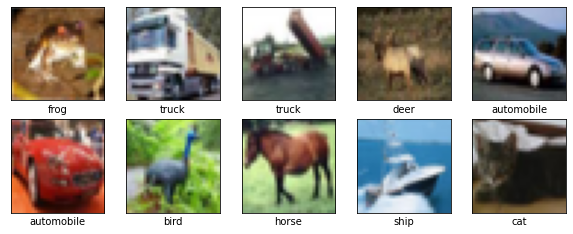

In [6]:
cifar10 = tf.keras.datasets.cifar10

(train_cifar_images, train_cifar_labels), (test_cifar_images, test_cifar_labels) = cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The CIFAR labels happen to be arrays
# So reshape them
train_cifar_labels = train_cifar_labels.reshape((-1,))
test_cifar_labels = test_cifar_labels.reshape((-1,))

train_cifar_images = (train_cifar_images.astype(np.float32) / 255)
train_cifar_labels = train_cifar_labels.astype(np.int32)

#Data Augmentation
datagen = ImageDataGenerator(
              rotation_range=15,
              horizontal_flip=True,
              width_shift_range=0.1,
              height_shift_range=0.1,
              zoom_range=0.2
            )
datagen.fit(train_cifar_images)


plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_cifar_images[i])
    plt.xlabel(class_names[train_cifar_labels[i]])
plt.show()


train_cifar_data = tf.data.Dataset.from_tensor_slices((train_cifar_images, train_cifar_labels))
train_cifar_data = train_cifar_data.shuffle(buffer_size=60000).batch(64)

# note: we batch the test data, but do not shuffle/repeat
test_cifar_data = tf.data.Dataset.from_tensor_slices(
    (test_cifar_images.astype(np.float32) / 255, test_cifar_labels.astype(np.int32))).batch(128)

# Generic Functions

## Applies the following dynamically



1.   BatchNorm
2.   Relu activation
3.   One Convolution layer



In [7]:
def dynamic_BatchNorm(x, kSize, curr_Dense_Block_Layer_Name, batchIndex=0, k_size=(1, 1), stride=1):
  x = tf.keras.layers.BatchNormalization(name=curr_Dense_Block_Layer_Name + "_" + "BatN" + "_" + str(batchIndex))(x)
  x = tf.keras.layers.Activation("relu", name=curr_Dense_Block_Layer_Name + "_" + "Act" + "_" + str(batchIndex))(x)
  x = tf.keras.layers.Conv2D(kSize, kernel_size=(1, 1), padding="same", strides=stride, name = curr_Dense_Block_Layer_Name + "_" + "BotN" + "_" + str(batchIndex))(x)

  return x

## Create  Dense_Block Layers dynamically


1.   Returns created Bense Block.
2.   Runs iteratively forthe specified number of layers.
3.   During every iteration it concatenates the previous X.



In [8]:
def dynamic_Dense_Block(layersSize, currDenseBlockName, inputX, kSize=32):

  for ind in range(layersSize):

    curr_Dense_Block_Layer_Name = currDenseBlockName + "_" + str(ind)
    x = dynamic_BatchNorm(inputX, 4*kSize, curr_Dense_Block_Layer_Name, 1)
    x = dynamic_BatchNorm(x, kSize, curr_Dense_Block_Layer_Name, 2, (3, 3))
    #Concatenation
    inputX = tf.keras.layers.concatenate([x, inputX], name=curr_Dense_Block_Layer_Name + "_Concat")

  return inputX

## Creates Transition Layers dynamically


1.   Applies BatchNorm
2.   One Convolution layer with kernel size=(1,1)
3.   Does the average pooling
4.   We are also removing the channels to half with a compression factor of 0.5(As per the paper)



In [9]:
def dynamic_Transition_Layer(inputX, transInd, stride=1):
  inpChannels = K.int_shape(inputX)[-1]
  compression = 0.5
  x = dynamic_BatchNorm(inputX, inpChannels*compression, "Trans_"+ str(transInd) , 0)
  x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=stride, padding="same", name= "Trans_"+ str(transInd) +"_AvgPool")(x)

  return x

## Creates Dense Net and returns the model

Note:- Call this param with different hyper params (can be supplied as parameters)

In [10]:
def dense_Net(configParams):

  #First Convolution
  inpX = tf.keras.layers.Input(configParams["input_shape"], name="InputLayer")
  x = tf.keras.layers.Conv2D(configParams["k"]*2, kernel_size=configParams["initial_Kernel_Size"], strides=configParams["initialStride"], padding="same", name='Conv0')(inpX)
  #x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=configParams["initialStride"], padding="same", name='Conv0MaxPool')(x)

  for idx, val in enumerate(configParams["dense_Layers_List"]):
    d_Out = dynamic_Dense_Block(val, "Dense_"+str(idx+1), x, configParams["k"])
    x = dynamic_Transition_Layer(d_Out, idx+1, configParams["transitionStride"])

  x = tf.keras.layers.GlobalAveragePooling2D(name= "GlobalAvgPool")(d_Out)
  x = tf.keras.layers.Dense(units=configParams["num_classes"], name='LinearDense')(x)

  func_model = tf.keras.Model(inpX, x, name=configParams["modelName"])

  return func_model

# Models Define

### Update Learning Rate Via a callback

In [11]:
def lr_scheduler(epoch, lr):
    if epoch % 20 == 0 or epoch % 30 == 0 :
        lr = lr/10
        return lr
    return lr

## Model Configs, Summary, Training, Testing

### V1  (DenseNet 121)

Observations:- The architecture is exactly the DenseNet-121 used for ImageNet challenge. But for the CIFAR10 dataset the accuracy for test dataset is 70% and 90% accuracy for training dataset. Trained for 20 epochs

In [12]:
dense_Model1_Config = {
    "input_shape": (32, 32, 3),
    "initial_Kernel_Size": (7, 7),
    "initialStride": 2,
    "transitionStride": 2,
    "num_classes": 10,
    "dense_Layers_List": [6, 12, 24, 16],
    "k": 32,
    "modelName": "DenseNet_V1",
}

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.70219 to fit



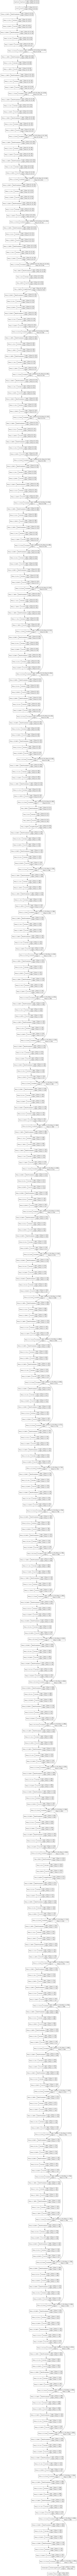

In [13]:
dense_Model1 = dense_Net(dense_Model1_Config)

#dense_Model1.summary()
tf.keras.utils.plot_model(dense_Model1, "DenseNet_V1.png", show_shapes=True)

In [14]:
## Training
dense_Model1.compile(
          loss      = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics   = tf.metrics.SparseCategoricalAccuracy(),
          optimizer = tf.optimizers.Adam())

dense_Model1.fit(train_cifar_data , epochs=20)

Epoch 1/20
782/782 [==============================] - 80s 68ms/step - loss: 1.5611 - sparse_categorical_accuracy: 0.4442
Epoch 2/20
782/782 [==============================] - 53s 67ms/step - loss: 1.1692 - sparse_categorical_accuracy: 0.5814
Epoch 3/20
782/782 [==============================] - 53s 67ms/step - loss: 1.0348 - sparse_categorical_accuracy: 0.6317
Epoch 4/20
782/782 [==============================] - 53s 68ms/step - loss: 0.9458 - sparse_categorical_accuracy: 0.6669
Epoch 5/20
782/782 [==============================] - 53s 67ms/step - loss: 0.8697 - sparse_categorical_accuracy: 0.6929
Epoch 6/20
782/782 [==============================] - 53s 67ms/step - loss: 0.8078 - sparse_categorical_accuracy: 0.7162
Epoch 7/20
782/782 [==============================] - 53s 68ms/step - loss: 0.7381 - sparse_categorical_accuracy: 0.7411
Epoch 8/20
782/782 [==============================] - 53s 68ms/step - loss: 0.6871 - sparse_categorical_accuracy: 0.7603
Epoch 9/20
782/782 [============

In [15]:
# evaluate test loss and metrics
dense_Model1.evaluate(test_cifar_data)

79/79 [==============================] - 4s 24ms/step - loss: 1.2751 - sparse_categorical_accuracy: 0.7055


[1.275100827217102, 0.7055000066757202]

### V2  (DenseNet)



1.   Three dense blocks.
2.   The size of the layers in each dense block is fixed by (L-4/3)(L is 40, growthRate K is 24).
3.   The training accuracy is 82% and the test dataset is 42% which is very poor.
4.   Trained for 20 epochs



In [16]:
#L=40,K=24
dense_Layers = int((40-4)/3)
dense_Model2_Config = {
    "input_shape": (32, 32, 3),
    "initial_Kernel_Size": (2, 2),
    "initialStride": 1,
    "transitionStride": 2,
    "num_classes": 10,
    "dense_Layers_List": [dense_Layers, dense_Layers, dense_Layers],
    "k": 24,
    "modelName": "DenseNet_V2"
}

In [19]:
dense_Model2 = dense_Net(dense_Model2_Config)

#dense_Model2.summary()
#tf.keras.utils.plot_model(dense_Model2, "DenseNet_V2.png", show_shapes=True)

In [20]:
#Training
dense_Model2.compile(
          loss      = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics   = tf.metrics.SparseCategoricalAccuracy(),
          #optimizer = tf.optimizers.SGD(learning_rate=0.1)
          optimizer = tf.optimizers.Adam()
          )

callbacks2 = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

dense_Model2.fit(train_cifar_data, epochs=20)

Epoch 1/20
782/782 [==============================] - 100s 118ms/step - loss: 1.4549 - sparse_categorical_accuracy: 0.4717
Epoch 2/20
782/782 [==============================] - 92s 117ms/step - loss: 1.1803 - sparse_categorical_accuracy: 0.5782
Epoch 3/20
782/782 [==============================] - 92s 117ms/step - loss: 1.0934 - sparse_categorical_accuracy: 0.6116
Epoch 4/20
782/782 [==============================] - 92s 117ms/step - loss: 1.0315 - sparse_categorical_accuracy: 0.6331
Epoch 5/20
782/782 [==============================] - 92s 118ms/step - loss: 0.9807 - sparse_categorical_accuracy: 0.6534
Epoch 6/20
782/782 [==============================] - 92s 117ms/step - loss: 0.9380 - sparse_categorical_accuracy: 0.6692
Epoch 7/20
782/782 [==============================] - 92s 117ms/step - loss: 0.9043 - sparse_categorical_accuracy: 0.6820
Epoch 8/20
782/782 [==============================] - 92s 117ms/step - loss: 0.8658 - sparse_categorical_accuracy: 0.6951
Epoch 9/20
782/782 [===

In [21]:
# evaluate test loss and metrics
dense_Model2.evaluate(test_cifar_data)

79/79 [==============================] - 7s 62ms/step - loss: 2.4785 - sparse_categorical_accuracy: 0.4742


[2.478518486022949, 0.4742000102996826]

### V3  (DenseNet)


1.   Three dense blocks.
2.   The size of the layers in each dense block is fixed by (L-4/3)(L is 60, growthRate K is 24).
3.   The training accuracy is 83% and the test dataset is 62% which is very poor.
4.   Trained for 20 epochs

In [22]:
#L=60,K=24
dense_Layers = int((60-4)/3)
dense_Model3_Config = {
    "input_shape": (32, 32, 3),
    "initial_Kernel_Size": (2, 2),
    "initialStride": 1,
    "transitionStride": 2,
    "num_classes": 10,
    "dense_Layers_List": [dense_Layers, dense_Layers, dense_Layers],
    "k": 24,
    "modelName": "DenseNet_V3"
}

In [23]:
dense_Model3 = dense_Net(dense_Model3_Config)

#dense_Model3.summary()
#tf.keras.utils.plot_model(dense_Model3, "DenseNet_V3.png", show_shapes=True)

In [24]:
#Training
dense_Model3.compile(
          loss      = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics   = tf.metrics.SparseCategoricalAccuracy(),
          #optimizer = tf.optimizers.SGD(learning_rate=0.1)
          optimizer = tf.optimizers.Adam()
          )

callbacks3 = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

dense_Model3.fit(train_cifar_data, epochs=20)

Epoch 1/20
782/782 [==============================] - 178s 214ms/step - loss: 1.4873 - sparse_categorical_accuracy: 0.4627
Epoch 2/20
782/782 [==============================] - 167s 213ms/step - loss: 1.2068 - sparse_categorical_accuracy: 0.5672
Epoch 3/20
782/782 [==============================] - 167s 213ms/step - loss: 1.1143 - sparse_categorical_accuracy: 0.6036
Epoch 4/20
782/782 [==============================] - 167s 213ms/step - loss: 1.0501 - sparse_categorical_accuracy: 0.6286
Epoch 5/20
782/782 [==============================] - 167s 213ms/step - loss: 1.0038 - sparse_categorical_accuracy: 0.6468
Epoch 6/20
782/782 [==============================] - 167s 213ms/step - loss: 0.9574 - sparse_categorical_accuracy: 0.6626
Epoch 7/20
782/782 [==============================] - 167s 213ms/step - loss: 0.9156 - sparse_categorical_accuracy: 0.6757
Epoch 8/20
782/782 [==============================] - 167s 213ms/step - loss: 0.8776 - sparse_categorical_accuracy: 0.6909
Epoch 9/20
782/7

In [25]:
# evaluate test loss and metrics
dense_Model3.evaluate(test_cifar_data)

79/79 [==============================] - 11s 109ms/step - loss: 1.3417 - sparse_categorical_accuracy: 0.6206


[1.3416975736618042, 0.6205999851226807]

### V4  (DenseNet)

1.   Three dense blocks.
2.   The size of the layers in each dense block is fixed by (L-4/3)(L is 80, growthRate K is 24).
4.   Trained for 20 epochs

In [ ]:
#L=80,K=24
dense_Layers = int((80-4)/3)
dense_Model4_Config = {
    "input_shape": (32, 32, 3),
    "initial_Kernel_Size": (2, 2),
    "initialStride": 1,
    "transitionStride": 2,
    "num_classes": 10,
    "dense_Layers_List": [dense_Layers, dense_Layers, dense_Layers],
    "k": 24,
    "modelName": "DenseNet_V4"
}

In [ ]:
dense_Model4 = dense_Net(dense_Model4_Config)

#dense_Model4.summary()
#tf.keras.utils.plot_model(dense_Model4, "DenseNet_V4.png", show_shapes=True)

In [ ]:
#Training
dense_Model4.compile(
          loss      = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics   = tf.metrics.SparseCategoricalAccuracy(),
          optimizer = tf.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False)
          # optimizer = tf.optimizers.Adam()
          )

callbacks4 = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

callback_ES = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

dense_Model4.fit(datagen.flow(train_cifar_images, train_cifar_labels, batch_size=128), epochs=100, callbacks=[callback_ES])

In [ ]:
# evaluate test loss and metrics
dense_Model4.evaluate(test_cifar_data)

### V5  (DenseNet)



1.   Training with less dense layers for longer epochs is overfitting.
2.   0.1 as validation split
3.   Three dense blocks.
4.   The size of the layers in each dense block is fixed by (L-4/3)(L is 40, growthRate K is 24).
5.   The training accuracy is 94% and the test dataset is None(forcefully stopped).
6.   100 epochs
7.   Observed that the model got overfitted for training dataset because for about 15 epochs the training accuracy is > 90% but the validation split accuracy is around 60%. I assume that the model is not learning any complex features so stopped the model forcefully.


In [ ]:
#L=40,K=24
dense_Layers = int((40-4)/3)
dense_Model5_Config = {
    "input_shape": (32, 32, 3),
    "initial_Kernel_Size": (2, 2),
    "initialStride": 1,
    "transitionStride": 2,
    "num_classes": 10,
    "dense_Layers_List": [dense_Layers, dense_Layers, dense_Layers],
    "k": 24,
    "modelName": "DenseNet_V5"
}

In [ ]:
dense_Model5 = dense_Net(dense_Model5_Config)

#dense_Model2.summary()
#tf.keras.utils.plot_model(dense_Model5, "DenseNet_V5.png", show_shapes=True)

In [ ]:
#Training
dense_Model5.compile(
          loss      = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics   = tf.metrics.SparseCategoricalAccuracy(),
          #optimizer = tf.optimizers.SGD(learning_rate=0.1)
          optimizer = tf.optimizers.Adam()
          )

callbacks2 = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

dense_Model5.fit(train_cifar_images, train_cifar_labels, epochs=100, validation_split=0.1, shuffle=True, batch_size=64)

Epoch 1/100
704/704 [==============================] - 114s 130ms/step - loss: 1.4833 - sparse_categorical_accuracy: 0.4657 - val_loss: 1.7963 - val_sparse_categorical_accuracy: 0.4148
Epoch 2/100
704/704 [==============================] - 87s 124ms/step - loss: 1.2136 - sparse_categorical_accuracy: 0.5670 - val_loss: 2.7741 - val_sparse_categorical_accuracy: 0.3446
Epoch 3/100
704/704 [==============================] - 87s 124ms/step - loss: 1.1217 - sparse_categorical_accuracy: 0.6010 - val_loss: 2.1252 - val_sparse_categorical_accuracy: 0.4058
Epoch 4/100
704/704 [==============================] - 87s 123ms/step - loss: 1.0555 - sparse_categorical_accuracy: 0.6250 - val_loss: 1.9652 - val_sparse_categorical_accuracy: 0.4352
Epoch 5/100
704/704 [==============================] - 87s 123ms/step - loss: 1.0089 - sparse_categorical_accuracy: 0.6424 - val_loss: 2.1641 - val_sparse_categorical_accuracy: 0.4310
Epoch 6/100
704/704 [==============================] - 87s 123ms/step - loss: 0

KeyboardInterrupt: ignored

In [ ]:
# evaluate test loss and metrics
dense_Model5.evaluate(test_cifar_data)

### V6  (DenseNet - Data Augmentation)

1.   Three dense blocks.
2.   The size of the layers in each dense block is fixed by (L-4/3)(L is 100, growthRate K is 24).
3.   The training accuracy is 69% and the test dataset is 48% which is very poor.
4.   Trained for 20 epochs
5.   The dense clock layer size has been increases, may be it should have been trained for more epochs.

In [ ]:
#L=100,K=24
dense_Layers = int((100-4)/3)
dense_Model6_Config = {
    "input_shape": (32, 32, 3),
    "initial_Kernel_Size": (2, 2),
    "initialStride": 1,
    "transitionStride": 2,
    "num_classes": 10,
    "dense_Layers_List": [dense_Layers, dense_Layers, dense_Layers],
    "k": 24,
    "modelName": "DenseNet_V6"
}

In [ ]:
dense_Model6 = dense_Net(dense_Model6_Config)

#dense_Model6.summary()
#tf.keras.utils.plot_model(dense_Model6, "DenseNet_V6.png", show_shapes=True)

In [ ]:
#Training
dense_Model6.compile(
          loss      = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics   = tf.metrics.SparseCategoricalAccuracy(),
          #optimizer = tf.optimizers.SGD(learning_rate=0.1)
          optimizer = tf.optimizers.Adam()
          )

callbacks4 = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

dense_Model6.fit(datagen.flow(train_cifar_images, train_cifar_labels, batch_size=64), epochs=20)

Epoch 1/20
782/782 [==============================] - 463s 543ms/step - loss: 1.6494 - sparse_categorical_accuracy: 0.4050
Epoch 2/20
782/782 [==============================] - 424s 542ms/step - loss: 1.3697 - sparse_categorical_accuracy: 0.5056
Epoch 3/20
782/782 [==============================] - 424s 542ms/step - loss: 1.2843 - sparse_categorical_accuracy: 0.5415
Epoch 4/20
782/782 [==============================] - 423s 541ms/step - loss: 1.2378 - sparse_categorical_accuracy: 0.5584
Epoch 5/20
782/782 [==============================] - 423s 541ms/step - loss: 1.1966 - sparse_categorical_accuracy: 0.5742
Epoch 6/20
782/782 [==============================] - 423s 541ms/step - loss: 1.1596 - sparse_categorical_accuracy: 0.5880
Epoch 7/20
782/782 [==============================] - 423s 542ms/step - loss: 1.1281 - sparse_categorical_accuracy: 0.6018
Epoch 8/20
782/782 [==============================] - 424s 542ms/step - loss: 1.0939 - sparse_categorical_accuracy: 0.6135
Epoch 9/20
782/7

In [ ]:
# evaluate test loss and metrics
dense_Model6.evaluate(test_cifar_data)

79/79 [==============================] - 27s 285ms/step - loss: 2.0149 - sparse_categorical_accuracy: 0.4845


[2.0149037837982178, 0.484499990940094]

### V7  (DenseNet 121_V2)


1.   The architecture is exactly the same DenseNet 121.
2.   The training accuracy is 72% and the test dataset is 59%.
3.   Trained for 20 epochs.
4.   In this training setting data augmentation has been applied.
5.   May be because of data augmentation the model should still learn features, model could have improved if tried for longer epochs

In [26]:
dense_Model7_Config = {
    "input_shape": (32, 32, 3),
    "initial_Kernel_Size": (2, 2),
    "initialStride": 1,
    "transitionStride": 2,
    "num_classes": 10,
    "dense_Layers_List": [6, 12, 24, 16],
    "k": 32,
    "modelName": "DenseNet_V7",
}

In [27]:
dense_Model7 = dense_Net(dense_Model7_Config)

#dense_Model1.summary()
#tf.keras.utils.plot_model(dense_Model1, "DenseNet_V1.png", show_shapes=True)

In [28]:
## Training
dense_Model7.compile(
          loss      = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics   = tf.metrics.SparseCategoricalAccuracy(),
          optimizer = tf.optimizers.Adam())

dense_Model7.fit(datagen.flow(train_cifar_images, train_cifar_labels, batch_size=64), epochs=20)

Epoch 1/20
782/782 [==============================] - 110s 126ms/step - loss: 1.6290 - sparse_categorical_accuracy: 0.4161
Epoch 2/20
782/782 [==============================] - 98s 126ms/step - loss: 1.3292 - sparse_categorical_accuracy: 0.5258
Epoch 3/20
782/782 [==============================] - 98s 126ms/step - loss: 1.2431 - sparse_categorical_accuracy: 0.5552
Epoch 4/20
782/782 [==============================] - 98s 126ms/step - loss: 1.1872 - sparse_categorical_accuracy: 0.5783
Epoch 5/20
782/782 [==============================] - 98s 126ms/step - loss: 1.1519 - sparse_categorical_accuracy: 0.5913
Epoch 6/20
782/782 [==============================] - 98s 125ms/step - loss: 1.1030 - sparse_categorical_accuracy: 0.6084
Epoch 7/20
782/782 [==============================] - 98s 125ms/step - loss: 1.0661 - sparse_categorical_accuracy: 0.6255
Epoch 8/20
782/782 [==============================] - 98s 125ms/step - loss: 1.0285 - sparse_categorical_accuracy: 0.6371
Epoch 9/20
782/782 [===

In [29]:
# evaluate test loss and metrics
dense_Model7.evaluate(test_cifar_data)

79/79 [==============================] - 7s 59ms/step - loss: 1.3295 - sparse_categorical_accuracy: 0.5908


[1.3295063972473145, 0.5907999873161316]

#References


1.   https://ovgu-ailab.github.io/idl2021/assignments/4/function_al.ipynb
2.   https://keras.io/api/models/model_training_apis/
3.   https://github.com/taki0112/Densenet-Tensorflow
4.   https://arxiv.org/pdf/1608.06993.pdf
5.   https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803
6.   https://stackoverflow.com/questions/59737875/keras-change-learning-rate
7.    https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
8.   https://www.youtube.com/watch?v=oV4YBitzXKw
9.   https://towardsdatascience.com/creating-densenet-121-with-tensorflow-edbc08a956d8
10.   https://github.com/kevinzakka/densenet/blob/master/model.py
